In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.ndimage import zoom

from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, recall_score, f1_score, precision_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms

import nibabel as nb

import os
import glob

# Functions 

In [2]:
# Finding File types
def find_dir(start_path, file_type):
    dir_list = []
    for root, _, files in os.walk(start_path): # Crawl through directory to find files
        if any(file.lower().endswith(file_type) for file in files): # Check for files types
            dir_list.append(root)
    return dir_list if dir_list else None  # Return Directory list if there are values inside, else return None

def file_paths(file_type, dir='datasets'):
    start_directory = f'/Users/jasonlee/Desktop/Personal_projects/alzheimers/{dir}' # Starting point directory  
    
    file_path_dir = find_dir(start_directory, file_type) # List of paths to directories 
    
    list_files = []
    for paths in file_path_dir: # Looping over list of directories
        for files in glob.glob(os.path.join(paths, f"*{file_type}")): # Looping over all files in directory
            list_files.append(files) 
    return list_files

def evaluate_model(model, dataloader, num_inputs=1):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Unpack depending on number of inputs
            if num_inputs == 1:
                images, labels = batch
                outputs = model(images)
            elif num_inputs == 2:
                (images1, images2), labels = batch
                outputs = model(images1, images2)
            else:
                raise ValueError("Only supports 1 or 2 model inputs")

            probs = torch.sigmoid(outputs)
            preds = probs >= 0.5

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.view(-1, 1).cpu().numpy())

    # Flatten to 1D arrays for scikit
    all_labels = [int(label[0]) for label in all_labels]
    all_preds = [int(pred[0]) for pred in all_preds]
    all_probs = [float(prob[0]) for prob in all_probs]

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    report = classification_report(all_labels, all_preds)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "classification_report": report
    }
    
def print_metrics(metrics, print_metrics=True, name='Training Set'):
    if print_metrics:
        print(f"\n{name} Metrics Report:")
        print(f"Accuracy:        {metrics['accuracy'] * 100:.2f}%")
        print(f"Precision:       {metrics['precision'] * 100:.2f}%")
        print(f"Recall:          {metrics['recall'] * 100:.2f}%")
        print(f"F1 Score:        {metrics['f1'] * 100:.2f}%")
        print(f"ROC AUC Score:   {metrics['roc_auc'] * 100:.2f}%")
        print("\nClassification Report:")
        print(metrics['classification_report'])
    else:
        print("Print metrics is false")

# PET Image slices

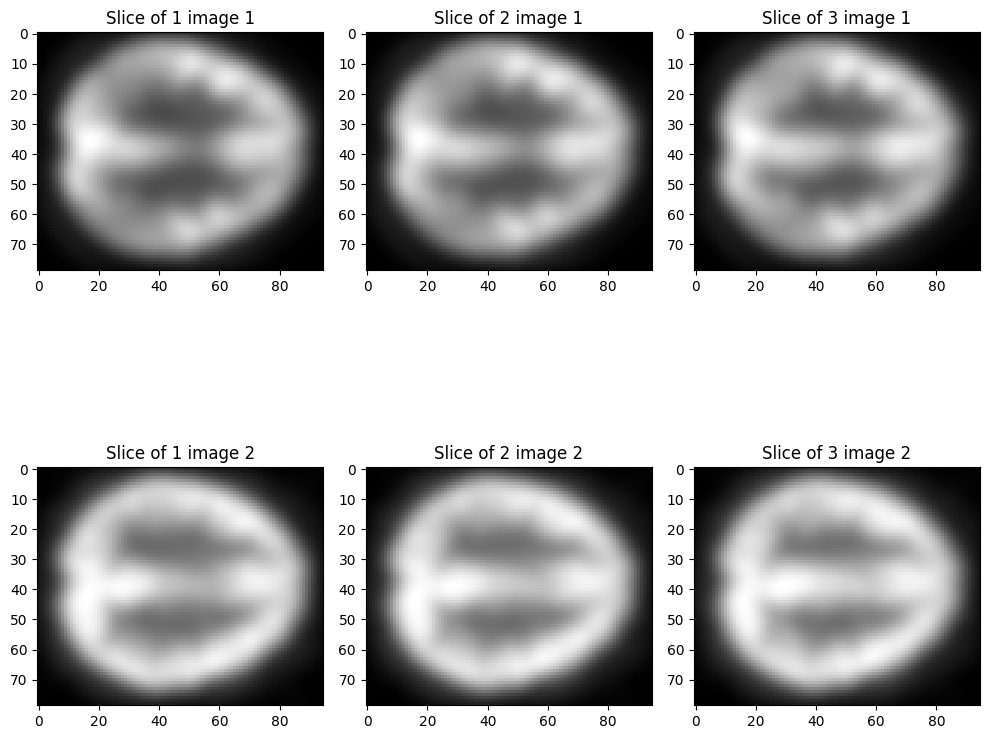

In [5]:
list_files = file_paths(file_type='.nii') # Getting all .nii files

# List of all raw images
img_list = []
for img_path in list_files:
    img = nb.load(img_path) # Load nii images
    img_list.append(img)
    
# List of arrays (converted from images)
array_list = []
for img in img_list:
    img_data = np.array(img.dataobj) # Converting image data to np array
    array_list.append(img_data)
    
n_uimg = len(img_list) # Number of unique images (meaning people)
n_rows = 3 # Number of subplot rows

# Graphing subplot images
fig, ax = plt.subplots(n_uimg, n_rows, figsize = (10,10)) # rows (n_uimg) x columns (n_rows)

for i, img in enumerate(array_list): # Rows loop
    for j in range(3): # Columns loop
        ax[i,j].imshow(img[:,:,40+j], cmap = 'gray') # i = rows, j = column, 40th + j slice, gray color map
        ax[i,j].set_title(f"Slice of {j+1} image {i+1}") 

plt.tight_layout()
plt.show()

##### NII file type
- Format type is x, y, z for height, length, and depth
- There is a 4th dimension, t, for time
- Similar to a deck of cards

##### PET Scan
- Not as accurate as MRI's 
- Different studies have shown different varying results in determining AD vs regular dementia or Parkinsons Disease 
- Scans amyloid plaque build up in the brain

##### PET Image Description
- Description: Tx origin, Spatially Normalized, Smoothed
    - Tx Origin
        - IDK
    - Spatially Normalized
        - Form of reshaping an image to the 'reference' brain space 
    - Smoothed
        - Process of averaging the signal in each voxel with a weighted average of the signal of neighboring voxels
            - Voxel (volume element) is a 3d square or rectangular chunk of brain
        - Gaussian kernel filter - form of convolution

# Saving to NPY files

In [ ]:
# --- 2D Arrays ---

# Getting csv's
df_list = file_paths('.csv')
df = pd.read_csv(df_list[1])
df_1 = pd.read_csv(df_list[0])

# Merge and clean dataframes
df = df_1.merge(df, on=['subject_id', 'visit'], how='outer')
df['DXAD'] = df['DXAD'].fillna(0).astype(int)
df = df[df['image_date'].notnull()][['subject_id', 'image_date', 'DXAD']].drop_duplicates()

# File path for nii files
nii_list = file_paths('.nii')

# Getting nii metadata 
nii_metadata = []
for nii_path in nii_list: # Looping over all nii files
    for row in df.itertuples(index=False): # Inner looping dataframe
        # Turning rows into variables
        subject_id_str = str(row.subject_id)
        image_date_str = str(row.image_date)

        # Condition to match subject and date to nii file
        if subject_id_str in nii_path and image_date_str in nii_path:
            nii_metadata.append({ # Append dictionary
                'subject_id': row.subject_id,
                'image_date': row.image_date,
                'DXAD': row.DXAD,
                'nii_path': nii_path
            })

# Process and save each nii slice to npy file
for item in nii_metadata:
    nii_img = nb.load(item['nii_path']) # Load nii file
    img_data = np.array(nii_img.dataobj) # Convert nii to np array

    num_slices = img_data.shape[2] # Dynamically get # of slices per nii file
    
    # Getting more slices for AD1 images
    if item['DXAD'] == 0:
        chosen_slices = np.arange(8, num_slices, 8).astype(int).tolist()
    else:
        chosen_slices = np.arange(3, num_slices, 3).astype(int).tolist()
        
    # Loop over the slice list
    for slice_idx in chosen_slices:
        arr = img_data[:, :, slice_idx] # Getting the array for specific slices
        output_file = f'datasets/subject_npy/subject{item["subject_id"]}_slice{slice_idx}_label_{item["DXAD"]}.npy'
        np.save(output_file, arr) 
        
        
# --- 3D Arrays ----
file_stuff = file_paths('.npy', dir='datasets/3d_npy')

label_cnt = {'label_1_cnt': 0, 'label_0_cnt': 0}

for item in file_stuff:
    label_cnt['label_1_cnt'] += item.count('label_1')
    label_cnt['label_0_cnt'] += item.count('label_0')
    
if label_cnt['label_0_cnt'] < label_cnt['label_1_cnt']:
    num_3d = label_cnt['label_0_cnt']
else:
    num_3d = label_cnt['label_1_cnt']

label_1_saved = 0
label_0_saved = 0

for i, item in enumerate(file_stuff):
    if 'label_1' in item and label_1_saved < num_3d:
        file_path = f'datasets/3d_npy_equal/label_1_{i}'
        arr = np.load(item)
        np.save(file_path, arr)
        label_1_saved += 1
        
    elif 'label_0' in item and label_0_saved < num_3d:
        file_path = f'datasets/3d_npy_equal/label_0_{i}'
        arr = np.load(item)
        np.save(file_path, arr)
        label_0_saved += 1

    if label_1_saved == num_3d and label_0_saved == num_3d:
        break

# <u>CNN Models<u>

## 2 Layer Classic CNN Model

Epoch [1/40], Loss: 0.6642
Epoch [1/40], Validation Loss: 0.6222
Epoch [2/40], Loss: 0.6003
Epoch [2/40], Validation Loss: 0.5714
Epoch [3/40], Loss: 0.5549
Epoch [3/40], Validation Loss: 0.5513
Epoch [4/40], Loss: 0.5159
Epoch [4/40], Validation Loss: 0.4562
Epoch [5/40], Loss: 0.4897
Epoch [5/40], Validation Loss: 0.4700
Epoch [6/40], Loss: 0.4701
Epoch [6/40], Validation Loss: 0.4361
Epoch [7/40], Loss: 0.4432
Epoch [7/40], Validation Loss: 0.4779
Epoch [8/40], Loss: 0.4336
Epoch [8/40], Validation Loss: 0.4372
Epoch [9/40], Loss: 0.4143
Epoch [9/40], Validation Loss: 0.3894
Epoch [10/40], Loss: 0.3909
Epoch [10/40], Validation Loss: 0.4152
Epoch [11/40], Loss: 0.3773
Epoch [11/40], Validation Loss: 0.4262
Epoch [12/40], Loss: 0.3592
Epoch [12/40], Validation Loss: 0.4127
Epoch [13/40], Loss: 0.3550
Epoch [13/40], Validation Loss: 0.3499
Epoch [14/40], Loss: 0.3383
Epoch [14/40], Validation Loss: 0.4955
Epoch [15/40], Loss: 0.3337
Epoch [15/40], Validation Loss: 0.4482
Epoch [16/40]

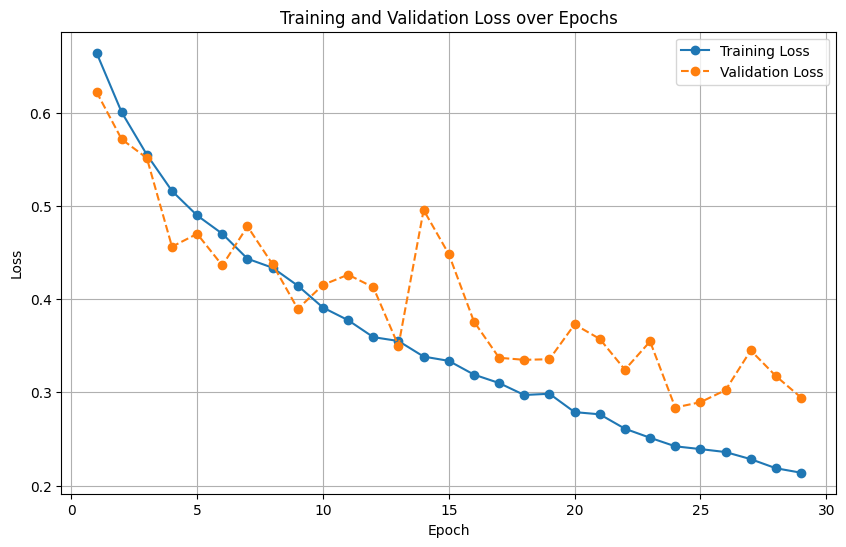


Training Set Metrics Report:
Accuracy:        87.31%
Precision:       93.26%
Recall:          81.37%
F1 Score:        86.91%
ROC AUC Score:   93.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        95
           1       0.93      0.81      0.87       102

    accuracy                           0.87       197
   macro avg       0.88      0.88      0.87       197
weighted avg       0.88      0.87      0.87       197



In [15]:
# Preprocess data
transform = transforms.Compose([ #  Chain multiple image transformations 
    transforms.ToPILImage(), # Convert numpy array to PIL image to resize
    transforms.Resize((70,70)), # Resize to have uniform length x height
    transforms.RandomHorizontalFlip(), # Random flip, data augmentation 
    transforms.ToTensor(), # Turn images to tensors (nd array objects)
    transforms.Normalize((0.5), (0.5)) # Normalize data between -1 and 1 for faster convergence
])

# Custom dataset with neuroimaging
class PET_Dataset(Dataset): # Inheriting Dataset subclass from Pytorch to ensure it works with DataLoader
    def __init__(self, npy_dir, transform=None):
        self.npy_dir = npy_dir # Directory with file names
        self.transform = transform # Transform pipeline 
        self.files = file_paths('.npy', dir=npy_dir) # List of all npy files
    
    # Required method in DataLoader class
    def __len__(self):
        return len(self.files) # Number of .npy files
    
    # Required method in DataLoader class
    def __getitem__(self, idx):
        file_path = os.path.join(self.npy_dir, self.files[idx]) # Gets file path for a given index
        
        slice_data = np.load(file_path) # Loads file into np array
        
        label = int(self.files[idx].split('_label_')[1].replace('.npy', '')) # Extracts DXAD label by str split and str replace
        
        # Transformation validation
        if self.transform:
            slice_data = self.transform(slice_data)
            
        return slice_data, label

# CNN Model
class PET_CNN(nn.Module):
    def __init__(self, dropout_rate = 0.4):
    # Determine what the Convolutional architecture looks like with different layers
        super().__init__()
        
        # 1st Conv layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1) # (68x68x16) (70 - 3 + 1 = 68) -> 34
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 34x34x64
        self.bnorm1 = nn.BatchNorm2d(64) # 64 layers input, Batch norm
        
        # 2nd Conv layer
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1) # (32x32x32) (34 - 3 + 1 = 32) -> 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 16x16x128
        self.bnorm2 = nn.BatchNorm2d(128) 
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(16 * 16 * 128, 256) # Multiplying the pixels to flatten
        self.fc2 = nn.Linear(256, 128) 
        self.fc3 = nn.Linear(128, 1) 
    
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
    # Progresses data across layers
        # 1st Conv layer
        x = F.relu(self.bnorm1(self.conv1(x))) # Relu activation function to break linearity after conv1 layer
        x = self.pool1(x) # Max pooling after relu
        
        # 2nd Conv Layer
        x = F.relu(self.bnorm2(self.conv2(x)))
        x = self.pool2(x)
        
        # Fully Connected Layer
        x = torch.flatten(x,1) # Turn images to vectors (1d array)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) # Binary output
        
        return x

# Splitting datasets into training, validation and testing
full_dataset = PET_Dataset(npy_dir='datasets/2d_npy', transform=transform) # Custom transformed dataset 
total_size = len(full_dataset) # Total size of dataset
train_size = int(0.8 * total_size) # 70% for training
val_size = int(0.1 * total_size) # 15% for validation
test_size = total_size - train_size - val_size # 15% remaining for testing
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size]) # Randomly splitting data

# Load custom dataset to Pytorch DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Pytorch DataLoader using custom Dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True) # No suffle
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True) # No shuffle
model = PET_CNN() # Instantiate CNN model to variable

# Training data
criterion = nn.BCEWithLogitsLoss() # For binary output
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Initialize variables for early stoppage
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
val_loss_history = []
train_loss_history = []

# Training loop
num_epochs = 40
for epoch in range(num_epochs): 
    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0 # Starting a running_loss variable with 0
    for images, labels in train_dataloader:
        optimizer.zero_grad() # Zero the gradient of each batch so the prior batch doesn't influence current batch
        
        outputs = model(images) # Returns a tensor of numbers per image, our y prediction (y_pred). Shape = (16 x 1 x 70 x70)
        labels = labels.float().view(-1,1) # Turns label (binary 1 -0) into float then vector column with shape (16 x 1)
        
        loss = criterion(outputs, labels) # BCEWithLogitsLoss formula 
        loss.backward() # Start backpropagation to calculate the gradients of the loss with respect to the parameters (weights & biases)
        
        optimizer.step() # Adam optimizer
        
        running_loss += loss.item() # Calculates total loss by converting tensor into int
    
    epoch_loss = running_loss / len(train_dataloader)    
    train_loss_history.append(epoch_loss)    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_outputs = model(val_images)
            val_labels = val_labels.float().view(-1,1)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    
    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_loss_history.append(val_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")
    
    # Early stopping Check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            break


# Graphing loss for training and validation
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label = 'Training Loss', marker = 'o', linestyle = '-')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label = 'Validation Loss', marker = 'o', linestyle = '--')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Saving our trained model with parameters
save_path = 'datasets/trained_model/2layer_classicCNN.pt'
torch.save(model.state_dict(), save_path)

# Loading best weights from early stoppage of classic cnn with 2d slices
model.load_state_dict(torch.load('datasets/trained_model/2layer_classicCNN.pt'))

# Getting scikit metrics 
test_metrics = evaluate_model(model, test_dataloader) # Returns dictionary

        
print_metrics(test_metrics)

<hr style="border: none; height: 10px; background-color: white;">

# 4 Layer Classic Conv

Epoch [1/40], Loss: 0.6834
Epoch [1/40], Validation Loss: 0.6776
Epoch [2/40], Loss: 0.6382
Epoch [2/40], Validation Loss: 0.6100
Epoch [3/40], Loss: 0.5842
Epoch [3/40], Validation Loss: 0.5608
Epoch [4/40], Loss: 0.5323
Epoch [4/40], Validation Loss: 0.5388
Epoch [5/40], Loss: 0.5127
Epoch [5/40], Validation Loss: 0.5306
Epoch [6/40], Loss: 0.4644
Epoch [6/40], Validation Loss: 0.5175
Epoch [7/40], Loss: 0.4286
Epoch [7/40], Validation Loss: 0.4866
Epoch [8/40], Loss: 0.3871
Epoch [8/40], Validation Loss: 0.4648
Epoch [9/40], Loss: 0.3514
Epoch [9/40], Validation Loss: 0.3975
Epoch [10/40], Loss: 0.3391
Epoch [10/40], Validation Loss: 0.4177
Epoch [11/40], Loss: 0.3093
Epoch [11/40], Validation Loss: 0.4069
Epoch [12/40], Loss: 0.2601
Epoch [12/40], Validation Loss: 0.4063
Epoch [13/40], Loss: 0.2516
Epoch [13/40], Validation Loss: 0.4432
Epoch [14/40], Loss: 0.2253
Epoch [14/40], Validation Loss: 0.3434
Epoch [15/40], Loss: 0.2020
Epoch [15/40], Validation Loss: 0.4008
Epoch [16/40]

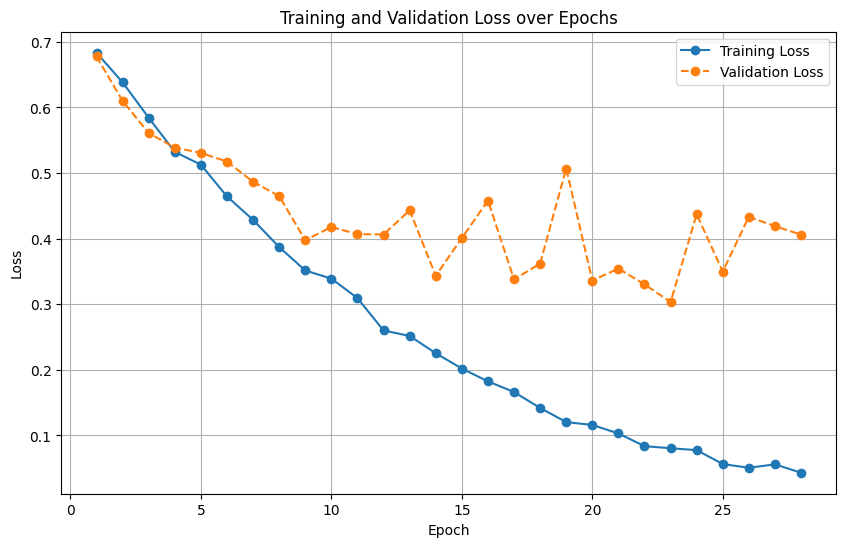


Training Set Metrics Report:
Accuracy:        86.80%
Precision:       85.71%
Recall:          90.57%
F1 Score:        88.07%
ROC AUC Score:   93.63%

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        91
           1       0.86      0.91      0.88       106

    accuracy                           0.87       197
   macro avg       0.87      0.86      0.87       197
weighted avg       0.87      0.87      0.87       197



In [7]:
# Preprocess data
transform = transforms.Compose([ #  Chain multiple image transformations 
    transforms.ToPILImage(), # Convert numpy array to PIL image to resize
    transforms.Resize((70,70)), # Resize to have uniform length x height
    transforms.RandomHorizontalFlip(), # Random flip, data augmentation 
    transforms.ToTensor(), # Turn images to tensors (nd array objects)
    transforms.Normalize((0.5), (0.5)) # Normalize data between -1 and 1 for faster convergence
])

# Custom dataset with neuroimaging
class PET_Dataset(Dataset): # Inheriting Dataset subclass from Pytorch to ensure it works with DataLoader
    def __init__(self, npy_dir, transform=None):
        self.npy_dir = npy_dir # Directory with file names
        self.transform = transform # Transform pipeline 
        self.files = file_paths('.npy', dir='datasets/2d_npy') # List of all npy files
    
    # Required method in DataLoader class
    def __len__(self):
        return len(self.files) # Number of .npy files
    
    # Required method in DataLoader class
    def __getitem__(self, idx):
        file_path = os.path.join(self.npy_dir, self.files[idx]) # Gets file path for a given index
        slice_data = np.load(file_path) # Loads file into np array
        
        label = int(self.files[idx].split('_label_')[1].replace('.npy', '')) # Extracts DXAD label by str split and str replace
        
        # Transformation validation
        if self.transform:
            slice_data = self.transform(slice_data)
            
        return slice_data, label

# CNN Model
class PET_CNN(nn.Module):
    def __init__(self, dropout_rate = 0.5):
    # Determine what the Convolutional architecture looks like with different layers
        super().__init__()
        
        # 1st Conv layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # 70x70x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 35x35x64
        self.bnorm1 = nn.BatchNorm2d(16) # 64 layers input, Batch norm
        
        # 2nd Conv layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1) # 33x33x128 output
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 16x16x128
        self.bnorm2 = nn.BatchNorm2d(32) 
        
        # 3rd Conv layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1) # 33x33x128 output
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 16x16x128
        self.bnorm3 = nn.BatchNorm2d(64) 
        
        # 4th Conv layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1) # 12x12x512 output
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 6x6x512
        self.bnorm4 = nn.BatchNorm2d(128) 
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(2 * 2 * 128, 128) # Multiplying the pixels to flatten
        self.fc2 = nn.Linear(128, 1) # Output only 1 classes, binary
    
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
    # Progresses data across layers
        # 1st Conv layer
        x = F.relu(self.bnorm1(self.conv1(x))) # Relu activation function to break linearity after conv1 layer
        x = self.pool1(x) # Max pooling after relu
        
        # 2nd Conv Layer
        x = F.relu(self.bnorm2(self.conv2(x)))
        x = self.pool2(x)
        
        # 3rd Conv Layer
        x = F.relu(self.bnorm3(self.conv3(x)))
        x = self.pool3(x)
        
        # 3rd Conv Layer
        x = F.relu(self.bnorm4(self.conv4(x)))
        x = self.pool4(x)
        
        # Fully Connected Layer
        x = torch.flatten(x,1) # Turn images to vectors (1d array)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # Binary output
        
        return x

# Splitting datasets into training, validation and testing
full_dataset = PET_Dataset(npy_dir='datasets/2d_npy', transform=transform) # Custom transformed dataset 
total_size = len(full_dataset) # Total size of dataset
train_size = int(0.8 * total_size) # 70% for training
val_size = int(0.1 * total_size) # 15% for validation
test_size = total_size - train_size - val_size # 15% remaining for testing
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size]) # Randomly splitting data

# Load custom dataset to Pytorch DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Pytorch DataLoader using custom Dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True) # No suffle
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True) # No shuffle
model = PET_CNN() # Instantiate CNN model to variable

# Training data
criterion = nn.BCEWithLogitsLoss() # For binary output
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Initialize variables for early stoppage
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
val_loss_history = []
train_loss_history = []

# Training loop
num_epochs = 40
for epoch in range(num_epochs): 
    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0 # Starting a running_loss variable with 0
    for images, labels in train_dataloader:
        optimizer.zero_grad() # Zero the gradient of each batch so the prior batch doesn't influence current batch
        
        outputs = model(images) # Returns a tensor of numbers per image, our y prediction (y_pred). Shape = (16 x 1 x 70 x70)
        labels = labels.float().view(-1,1) # Turns label (binary 1 -0) into float then vector column with shape (16 x 1)
        
        loss = criterion(outputs, labels) # BCEWithLogitsLoss formula 
        loss.backward() # Start backpropagation to calculate the gradients of the loss with respect to the parameters (weights & biases)
        
        optimizer.step() # Adam optimizer
        
        running_loss += loss.item() # Calculates total loss by converting tensor into int
    
    epoch_loss = running_loss / len(train_dataloader)    
    train_loss_history.append(epoch_loss)    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_outputs = model(val_images)
            val_labels = val_labels.float().view(-1,1)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    
    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_loss_history.append(val_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")
    
    # Early stopping Check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            break


# Graphing loss for training and validation
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label = 'Training Loss', marker = 'o', linestyle = '-')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label = 'Validation Loss', marker = 'o', linestyle = '--')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Saving our trained model with parameters
save_path = 'datasets/trained_model/4layer_classicCNN.pt'
torch.save(model.state_dict(), save_path)

model = PET_CNN()
model.load_state_dict(best_model_state)
# Getting scikit metrics 
test_metrics = evaluate_model(model, test_dataloader) # Returns dictionary

        
print_metrics(test_metrics)

<hr style="border: none; height: 10px; background-color: white;">

## ResNet 

/Users/jasonlee/Desktop/Personal_projects/alzheimers/tf_venv/lib/python3.11/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/40], Loss: 0.6386
Epoch [1/40], Validation Loss: 1.2443
Epoch [2/40], Loss: 0.5969
Epoch [2/40], Validation Loss: 2.7301
Epoch [3/40], Loss: 0.5829
Epoch [3/40], Validation Loss: 1.0578
Epoch [4/40], Loss: 0.5627
Epoch [4/40], Validation Loss: 1.0316
Epoch [5/40], Loss: 0.5532
Epoch [5/40], Validation Loss: 0.7373
Epoch [6/40], Loss: 0.5262
Epoch [6/40], Validation Loss: 0.8201
Epoch [7/40], Loss: 0.5062
Epoch [7/40], Validation Loss: 0.7461
Epoch [8/40], Loss: 0.5065
Epoch [8/40], Validation Loss: 0.5520
Epoch [9/40], Loss: 0.4810
Epoch [9/40], Validation Loss: 0.6057
Epoch [10/40], Loss: 0.4720
Epoch [10/40], Validation Loss: 0.5437
Epoch [11/40], Loss: 0.4559
Epoch [11/40], Validation Loss: 0.6645
Epoch [12/40], Loss: 0.4385
Epoch [12/40], Validation Loss: 0.7599
Epoch [13/40], Loss: 0.4410
Epoch [13/40], Validation Loss: 0.6741
Epoch [14/40], Loss: 0.3960
Epoch [14/40], Validation Loss: 0.5676
Epoch [15/40], Loss: 0.3975
Epoch [15/40], Validation Loss: 0.8667


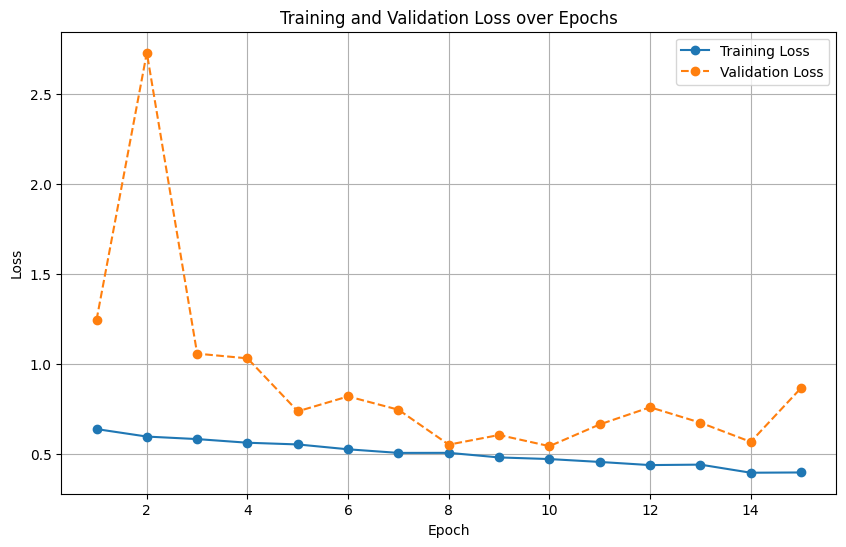


ResNet Training Set Metrics Report:
Accuracy:        70.34%
Precision:       64.57%
Recall:          96.09%
F1 Score:        77.24%
ROC AUC Score:   90.78%

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.42      0.57       652
           1       0.65      0.96      0.77       717

    accuracy                           0.70      1369
   macro avg       0.78      0.69      0.67      1369
weighted avg       0.77      0.70      0.68      1369



In [ ]:
# Preprocess data
transform = transforms.Compose([ #  Chain multiple image transformations 
    transforms.ToPILImage(), # Convert numpy array to PIL image to resize
    transforms.Resize((70,70)), # Resize to have uniform length x height
    transforms.RandomHorizontalFlip(), # Random flip, data augmentation 
    transforms.ToTensor(), # Turn images to tensors (nd array objects)
    transforms.Normalize((0.5), (0.5)) # Normalize data between -1 and 1 for faster convergence
])

# Custom dataset with neuroimaging
class PET_Dataset(Dataset): # Inheriting Dataset subclass from Pytorch to ensure it works with DataLoader
    def __init__(self, npy_dir, transform=None):
        self.npy_dir = npy_dir # Directory with file names
        self.transform = transform # Transform pipeline 
        self.files = file_paths('.npy', dir=npy_dir) # List of all npy files
    
    # Required method in DataLoader class
    def __len__(self):
        return len(self.files) # Number of .npy files
    
    # Required method in DataLoader class
    def __getitem__(self, idx):
        file_path = os.path.join(self.npy_dir, self.files[idx]) # Gets file path for a given index
        
        slice_data = np.load(file_path) # Loads file into np array
        
        label = int(self.files[idx].split('_label_')[1].replace('.npy', '')) # Extracts DXAD label by str split and str replace
        
        # Transformation validation
        if self.transform:
            slice_data = self.transform(slice_data)
            
        return slice_data, label

# Creating Residual Block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        # 1st Conv Layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False), 
            nn.BatchNorm2d(out_channels), # Batch norm
            nn.ReLU(inplace=True) # Relu activation function
        )
        
        # 2nd Conv layer 
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        # Initialize variables
        self.downsample = downsample # Downsample for when the output of Conv layer is smaller than Res block
        self.relu = nn.ReLU(inplace=True) # Initialize Relu activation function into class
    
    # Forward function for forward pass        
    def forward(self, x):
        residual = x # Initialize residual (original) block
        
        out = self.conv1(x) # 1st conv layer
        out = self.conv2(out) # 2nd conv layer
        
        # If there is a downsample the Residual is the downsample'd block
        if self.downsample:
            residual = self.downsample(x)
        
        out += residual # Add residual (shortcut connection)
        out = self.relu(out) # Relu the output
        
        return out

# ResNet Model 
class PET_ResNet(nn.Module):
    def __init__(self, block=ResBlock, layers=[2,2], num_classes=1, dropout_rate=0.3):
        super().__init__()
        self.in_channels = 64
        
        # Initial Conv layer
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False), # Keeps dimensions of original input bc padding=1
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1) # Half the dimensions w/ stride & kernel = 2
        ) # Output 64 output channels
        
        # Residual layers w/ _maker_layer helper function
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # Global average pooling
        self.fc = nn.Sequential(
            nn.Linear(128, 256), # 128 neuron layer to 256 neuron layer
            nn.ReLU(), # Relu 
            nn.Dropout2d(dropout_rate), # Randomly drop out
            nn.Linear(256, num_classes)# 256 neuron layer to 1 neuron for binary
        )
        
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None # Initialize downsample as None to begin with
        
        # Check if downsampling is needed by checking stride (reduces dimensions) or number of channels
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential( # Create downsample 'frame' to alter the input
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
        layers = [block(self.in_channels, out_channels, stride, downsample)] # Create list with 1st value being ResBlock instance
        self.in_channels = out_channels # Setting input to output channels since all subsequent channels will have the same dim
        
        for _ in range(1, blocks): # Starting from 1 because 1st instance is already created 
            layers.append(block(self.in_channels, out_channels)) # Append ResBlock to layers list
            
        return nn.Sequential(*layers) # Unpacking the arguments to use in nn.Sequential
    
    def forward(self, x):
        # Forward pass
        x = self.initial(x) # 1st Conv layer
        x = self.layer1(x) 
        x = self.layer2(x)
        x = self.avgpool(x) # Global average pooling 
        x = torch.flatten(x, 1) # Flatten to 1d vector
        x = self.fc(x) # Go through fully connected layer
        
        return x


# Splitting datasets into training, validation and testing
full_dataset = PET_Dataset(npy_dir='datasets/2d_npy', transform=transform) # Custom transformed dataset 
total_size = len(full_dataset) # Total size of dataset
train_size = int(0.7 * total_size) # 70% for training
val_size = int(0.15 * total_size) # 15% for validation
test_size = total_size - train_size - val_size # 15% remaining for testing
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size]) # Randomly splitting data

# Load custom dataset to Pytorch DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Pytorch DataLoader using custom Dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True) # No suffle
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True) # No shuffle
model = PET_ResNet() # Instantiate CNN model to variable

# Training data
criterion = nn.BCEWithLogitsLoss() # For binary output
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Initialize variables for early stoppage
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
val_loss_history = []
train_loss_history = []

# Training loop
num_epochs = 40
for epoch in range(num_epochs): 
    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0 # Starting a running_loss variable with 0
    for images, labels in train_dataloader:
        optimizer.zero_grad() # Zero the gradient of each batch so the prior batch doesn't influence current batch
        
        outputs = model(images) # Returns a tensor of numbers per image, our y prediction (y_pred). Shape = (16 x 1 x 70 x70)
        labels = labels.float().view(-1,1) # Turns label (binary 1 -0) into float then vector column with shape (16 x 1)
        
        loss = criterion(outputs, labels) # BCEWithLogitsLoss formula 
        loss.backward() # Start backpropagation to calculate the gradients of the loss with respect to the parameters (weights & biases)
        
        optimizer.step() # Adam optimizer
        
        running_loss += loss.item() # Calculates total loss by converting tensor into int
    
    epoch_loss = running_loss / len(train_dataloader)    
    train_loss_history.append(epoch_loss)    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_outputs = model(val_images)
            val_labels = val_labels.float().view(-1,1)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    
    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_loss_history.append(val_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")
    
    # Early stopping Check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            break


# Graphing loss for training and validation
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label = 'Training Loss', marker = 'o', linestyle = '-')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label = 'Validation Loss', marker = 'o', linestyle = '--')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Saving our trained model with parameters
save_path = 'datasets/trained_model/resnet.pt'
torch.save(model.state_dict(), save_path)

# Loading best weights from early stoppage of classic cnn with 2d slices
model.load_state_dict(torch.load('datasets/trained_model/resnet.pt'))

# Getting scikit metrics 
test_metrics = evaluate_model(model, test_dataloader) # Returns dictionary

        
print_metrics(test_metrics)

<hr style="border: none; height: 10px; background-color: white;">

# LeNet-5

Epoch [1/40], Loss: 0.6379
Epoch [1/40], Validation Loss: 0.5874
Epoch [2/40], Loss: 0.5371
Epoch [2/40], Validation Loss: 0.4803
Epoch [3/40], Loss: 0.4812
Epoch [3/40], Validation Loss: 0.4447
Epoch [4/40], Loss: 0.4243
Epoch [4/40], Validation Loss: 0.3911
Epoch [5/40], Loss: 0.3863
Epoch [5/40], Validation Loss: 0.3831
Epoch [6/40], Loss: 0.3759
Epoch [6/40], Validation Loss: 0.3949
Epoch [7/40], Loss: 0.3214
Epoch [7/40], Validation Loss: 0.3599
Epoch [8/40], Loss: 0.3091
Epoch [8/40], Validation Loss: 0.3401
Epoch [9/40], Loss: 0.2902
Epoch [9/40], Validation Loss: 0.3387
Epoch [10/40], Loss: 0.2738
Epoch [10/40], Validation Loss: 0.3268
Epoch [11/40], Loss: 0.2513
Epoch [11/40], Validation Loss: 0.3085
Epoch [12/40], Loss: 0.2394
Epoch [12/40], Validation Loss: 0.3241
Epoch [13/40], Loss: 0.2267
Epoch [13/40], Validation Loss: 0.3253
Epoch [14/40], Loss: 0.2158
Epoch [14/40], Validation Loss: 0.2977
Epoch [15/40], Loss: 0.1984
Epoch [15/40], Validation Loss: 0.3051
Epoch [16/40]

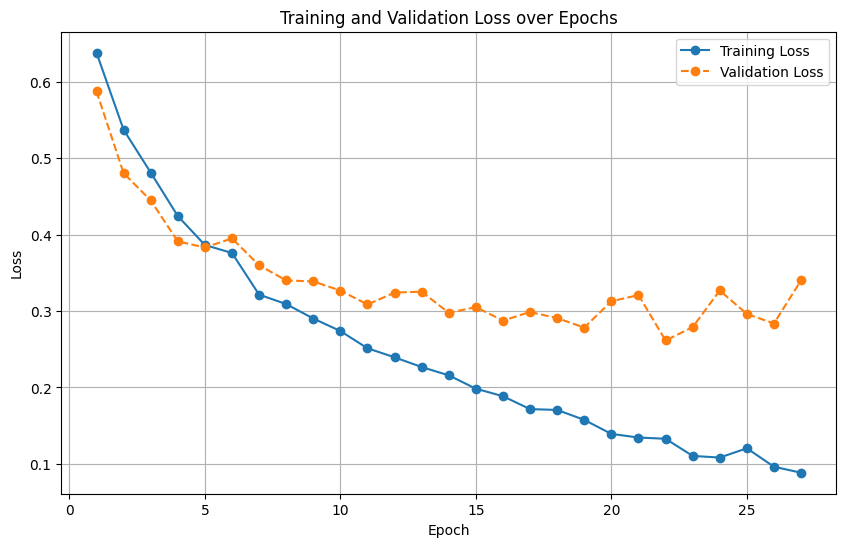


Training Set Metrics Report:
Accuracy:        88.10%
Precision:       91.67%
Recall:          85.16%
F1 Score:        88.29%
ROC AUC Score:   94.94%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       139
           1       0.92      0.85      0.88       155

    accuracy                           0.88       294
   macro avg       0.88      0.88      0.88       294
weighted avg       0.88      0.88      0.88       294



In [17]:
# Preprocess data
transform = transforms.Compose([ #  Chain multiple image transformations 
    transforms.ToPILImage(), # Convert numpy array to PIL image to resize
    transforms.Resize((70,70)), # Resize to have uniform length x height
    transforms.RandomHorizontalFlip(), # Random flip, data augmentation 
    transforms.ToTensor(), # Turn images to tensors (nd array objects)
    transforms.Normalize((0.5), (0.5)) # Normalize data between -1 and 1 for faster convergence
])

# Custom dataset with neuroimaging
class PET_Dataset(Dataset): # Inheriting Dataset subclass from Pytorch to ensure it works with DataLoader
    def __init__(self, npy_dir, transform=None):
        self.npy_dir = npy_dir # Directory with file names
        self.transform = transform # Transform pipeline 
        self.files = file_paths('.npy', dir=npy_dir) # List of all npy files
    
    # Required method in DataLoader class
    def __len__(self):
        return len(self.files) # Number of .npy files
    
    # Required method in DataLoader class
    def __getitem__(self, idx):
        file_path = os.path.join(self.npy_dir, self.files[idx]) # Gets file path for a given index
        
        slice_data = np.load(file_path) # Loads file into np array
        
        label = int(self.files[idx].split('_label_')[1].replace('.npy', '')) # Extracts DXAD label by str split and str replace
        
        # Transformation validation
        if self.transform:
            slice_data = self.transform(slice_data)
            
        return slice_data, label

# CNN Model
class PET_CNN(nn.Module):
    def __init__(self, dropout_rate = 0.2):
    # Determine what the Convolutional architecture looks like with different layers
        super().__init__()
        
        # 1st Conv layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1) # 66x66x6
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) # 33x33x6
        self.bnorm1 = nn.BatchNorm2d(10) # 6 layers input, Batch norm
        
        # 2nd Conv layer
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1) # 29x29x16
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) # 14x14x16
        self.bnorm2 = nn.BatchNorm2d(20) # 16 layers input, Batch norm
        
        # 3rd Conv layer
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, stride=1) # 10x10x32
        self.bnorm3 = nn.BatchNorm2d(40) # 32 layers input, Batch norm
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(10 * 10 * 40, 84) # Multiplying the pixels to flatten
        self.fc2 = nn.Linear(84, 1) # Output only 1 classes, binary
    
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
    # Progresses data across layers
        # 1st Conv layer
        x = F.relu(self.bnorm1(self.conv1(x))) # Relu activation function to break linearity after conv1 layer
        x = self.pool1(x) # Max pooling after relu
        
        # 2nd Conv Layer
        x = F.relu(self.bnorm2(self.conv2(x)))
        x = self.pool2(x)
        
        # 3rd Conv Layer
        x = F.relu(self.bnorm3(self.conv3(x)))
        
        # Fully Connected Layer
        x = torch.flatten(x,1) # Turn images to vectors (1d array)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # Binary output
        
        return x

# Splitting datasets into training, validation and testing
full_dataset = PET_Dataset(npy_dir='datasets/2d_npy', transform=transform) # Custom transformed dataset 
total_size = len(full_dataset) # Total size of dataset
train_size = int(0.7 * total_size) # 70% for training
val_size = int(0.15 * total_size) # 15% for validation
test_size = total_size - train_size - val_size # 15% remaining for testing
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size]) # Randomly splitting data

# Load custom dataset to Pytorch DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Pytorch DataLoader using custom Dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True) # No suffle
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True) # No shuffle
model = PET_CNN() # Instantiate CNN model to variable

# Training data
criterion = nn.BCEWithLogitsLoss() # For binary output
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

# Initialize variables for early stoppage
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
val_loss_history = []
train_loss_history = []

# Training loop
num_epochs = 40
for epoch in range(num_epochs): 
    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0 # Starting a running_loss variable with 0
    for images, labels in train_dataloader:
        optimizer.zero_grad() # Zero the gradient of each batch so the prior batch doesn't influence current batch
        
        outputs = model(images) # Returns a tensor of numbers per image, our y prediction (y_pred). Shape = (16 x 1 x 70 x70)
        labels = labels.float().view(-1,1) # Turns label (binary 1 -0) into float then vector column with shape (16 x 1)
        
        loss = criterion(outputs, labels) # BCEWithLogitsLoss formula 
        loss.backward() # Start backpropagation to calculate the gradients of the loss with respect to the parameters (weights & biases)
        
        optimizer.step() # Adam optimizer
        
        running_loss += loss.item() # Calculates total loss by converting tensor into int
    
    epoch_loss = running_loss / len(train_dataloader)    
    train_loss_history.append(epoch_loss)    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_outputs = model(val_images)
            val_labels = val_labels.float().view(-1,1)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    
    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_loss_history.append(val_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")
    
    # Early stopping Check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            break


# Graphing loss for training and validation
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label = 'Training Loss', marker = 'o', linestyle = '-')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label = 'Validation Loss', marker = 'o', linestyle = '--')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Saving our trained model with parameters
save_path = 'datasets/trained_model/letnet-5.pt'
torch.save(model.state_dict(), save_path)

model = PET_CNN()
model.load_state_dict(best_model_state)
# Getting scikit metrics 
test_metrics = evaluate_model(model, test_dataloader) # Returns dictionary


print_metrics(test_metrics)

<hr style="border: none; height: 10px; background-color: white;">

# NovelCNN
### https://www.nature.com/articles/s41598-024-53733-6

Epoch [1/40], Loss: 13.1960
Epoch [1/40], Validation Loss: 4.6621
Epoch [2/40], Loss: 3.6391
Epoch [2/40], Validation Loss: 1.6752
Epoch [3/40], Loss: 1.3678
Epoch [3/40], Validation Loss: 1.1167
Epoch [4/40], Loss: 0.6717
Epoch [4/40], Validation Loss: 0.4752
Epoch [5/40], Loss: 0.4147
Epoch [5/40], Validation Loss: 0.4861
Epoch [6/40], Loss: 0.3527
Epoch [6/40], Validation Loss: 0.5046
Epoch [7/40], Loss: 0.3351
Epoch [7/40], Validation Loss: 0.3845
Epoch [8/40], Loss: 0.2950
Epoch [8/40], Validation Loss: 0.9334
Epoch [9/40], Loss: 0.2916
Epoch [9/40], Validation Loss: 0.5342
Epoch [10/40], Loss: 0.2851
Epoch [10/40], Validation Loss: 1.6375
Epoch [11/40], Loss: 0.2454
Epoch [11/40], Validation Loss: 0.4605
Epoch [12/40], Loss: 0.2327
Epoch [12/40], Validation Loss: 0.5169


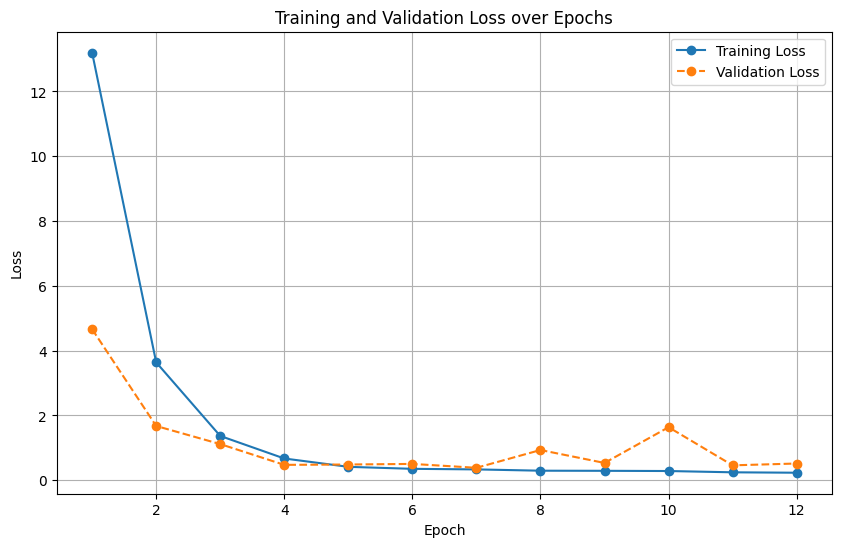


Training Set Metrics Report:
Accuracy:        81.29%
Precision:       89.52%
Recall:          72.55%
F1 Score:        80.14%
ROC AUC Score:   91.29%

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82       141
           1       0.90      0.73      0.80       153

    accuracy                           0.81       294
   macro avg       0.82      0.82      0.81       294
weighted avg       0.83      0.81      0.81       294



In [3]:
# Preprocess data
transform = transforms.Compose([ #  Chain multiple image transformations 
    transforms.ToPILImage(), # Convert numpy array to PIL image to resize
    transforms.Resize((224,224)), # Resize to have uniform length x height
    transforms.RandomHorizontalFlip(), # Random flip, data augmentation 
    transforms.ToTensor(), # Turn images to tensors (nd array objects)
    transforms.Normalize((0.5), (0.5)) # Normalize data between -1 and 1 for faster convergence
])

# Custom dataset with neuroimaging
class PET_Dataset(Dataset): # Inheriting Dataset subclass from Pytorch to ensure it works with DataLoader
    def __init__(self, npy_dir, transform=None):
        self.npy_dir = npy_dir # Directory with file names
        self.transform = transform # Transform pipeline 
        self.files = file_paths('.npy', dir='datasets/2d_npy') # List of all npy files
    
    # Required method in DataLoader class
    def __len__(self):
        return len(self.files) # Number of .npy files
    
    # Required method in DataLoader class
    def __getitem__(self, idx):
        file_path = os.path.join(self.npy_dir, self.files[idx]) # Gets file path for a given index
        
        slice_data = np.load(file_path) # Loads file into np array
        
        label = int(self.files[idx].split('_label_')[1].replace('.npy', '')) # Extracts DXAD label by str split and str replace
        
        # Transformation validation
        if self.transform:
            slice_data = self.transform(slice_data)
            
        return (slice_data, slice_data), label

# Reusable CNN block 
class CNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        return x
    
# 1st CNN Class
class PET_CNN1(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.conv_block1 = CNN_Block(1, 16)
        self.conv_block2 = CNN_Block(16, 64)
        self.conv_block3 = CNN_Block(64, 256)
        self.bnorm1 = nn.BatchNorm2d(256)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(26 * 26 * 256, 128)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.bnorm1(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        return x
    
# 2nd CNN Class
class PET_CNN2(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.conv_block1 = CNN_Block(1, 32, kernel_size=5)
        self.conv_block2 = CNN_Block(32, 128, kernel_size=5)
        self.conv_block3 = CNN_Block(128, 512, kernel_size=5)
        self.bnorm1 = nn.BatchNorm2d(512)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(24 * 24 * 512, 128)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.bnorm1(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        return x
    
# Concat 2 classes
class PET_CNN_Concat(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.branch1 = PET_CNN1(dropout_rate)
        self.branch2 = PET_CNN2(dropout_rate)
        self.concat_fc = nn.Linear(128 + 128, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x1, x2):
        out1 = self.branch1(x1)
        out2 = self.branch2(x2)
        combined = torch.cat((out1, out2), dim=1)
        output = self.dropout(combined)
        output = self.concat_fc(output)
        return output
    
# Splitting datasets into training, validation and testing
full_dataset = PET_Dataset(npy_dir='datasets/2d_npy', transform=transform) # Custom transformed dataset 
total_size = len(full_dataset) # Total size of dataset
train_size = int(0.7 * total_size) # 70% for training
val_size = int(0.15 * total_size) # 15% for validation
test_size = total_size - train_size - val_size # 15% remaining for testing
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size]) # Randomly splitting data

# Load custom dataset to Pytorch DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Pytorch DataLoader using custom Dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True) # No suffle
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True) # No shuffle
model = PET_CNN_Concat() # Instantiate CNN model to variable

# Training data
criterion = nn.BCEWithLogitsLoss() # For binary output
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Initialize variables for early stoppage
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
val_loss_history = []
train_loss_history = []

# Training loop
num_epochs = 40
for epoch in range(num_epochs): 
    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0 # Starting a running_loss variable with 0
    for (images1, images2), labels in train_dataloader:
        optimizer.zero_grad() # Zero the gradient of each batch so the prior batch doesn't influence current batch
        
        outputs = model(images1, images2) # Returns a tensor of numbers per image, our y prediction (y_pred). Shape = (16 x 1 x 70 x70)
        labels = labels.float().view(-1,1) # Turns label (binary 1 -0) into float then vector column with shape (16 x 1)
        
        loss = criterion(outputs, labels) # BCEWithLogitsLoss formula 
        loss.backward() # Start backpropagation to calculate the gradients of the loss with respect to the parameters (weights & biases)
        
        optimizer.step() # Adam optimizer
        
        running_loss += loss.item() # Calculates total loss by converting tensor into int
    
    epoch_loss = running_loss / len(train_dataloader)    
    train_loss_history.append(epoch_loss)    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for (val_images1, val_images2), val_labels in val_dataloader:
            val_outputs = model(val_images1, val_images2)
            val_labels = val_labels.float().view(-1,1)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    
    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_loss_history.append(val_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")
    
    # Early stopping Check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            break


# Graphing loss for training and validation
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label = 'Training Loss', marker = 'o', linestyle = '-')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label = 'Validation Loss', marker = 'o', linestyle = '--')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Saving our trained model with parameters
save_path = 'datasets/trained_model/novel_cnn.pt'
torch.save(model.state_dict(), save_path)

model = PET_CNN_Concat()
model.load_state_dict(best_model_state)
# Getting scikit metrics 
test_metrics = evaluate_model(model, test_dataloader, num_inputs=2) # Returns dictionary


print_metrics(test_metrics)

<hr style="border: none; height: 10px; background-color: white;">

# 3d CNN

Epoch [1/40], Loss: 0.6462
Epoch [1/40], Validation Loss: 0.6936
Epoch [2/40], Loss: 0.4046
Epoch [2/40], Validation Loss: 0.5787
Epoch [3/40], Loss: 0.5057
Epoch [3/40], Validation Loss: 0.6324
Epoch [4/40], Loss: 0.3873
Epoch [4/40], Validation Loss: 0.5293
Epoch [5/40], Loss: 0.2909
Epoch [5/40], Validation Loss: 0.3006
Epoch [6/40], Loss: 0.3225
Epoch [6/40], Validation Loss: 0.6773
Epoch [7/40], Loss: 0.2224
Epoch [7/40], Validation Loss: 0.6231
Epoch [8/40], Loss: 0.2185
Epoch [8/40], Validation Loss: 0.5261
Epoch [9/40], Loss: 0.2054
Epoch [9/40], Validation Loss: 0.4519
Epoch [10/40], Loss: 0.1584
Epoch [10/40], Validation Loss: 0.8086


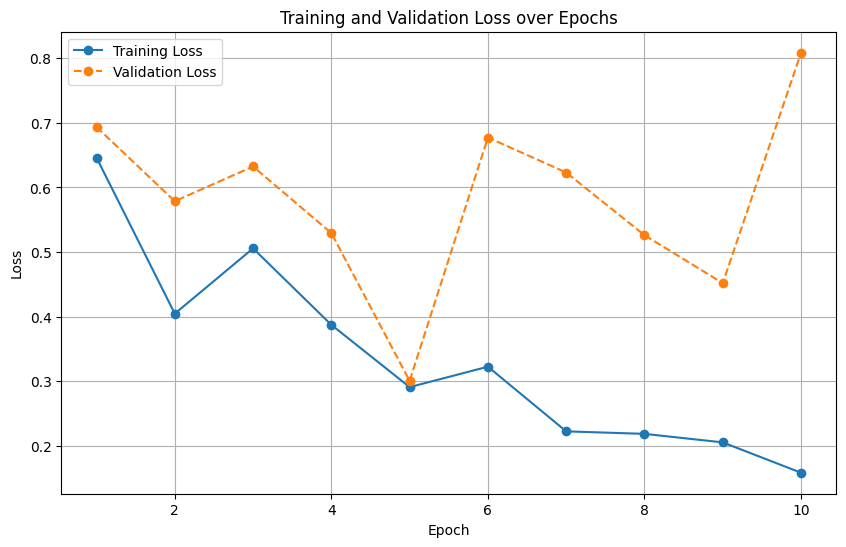


Training Set Metrics Report:
Accuracy:        88.60%
Precision:       72.34%
Recall:          100.00%
F1 Score:        83.95%
ROC AUC Score:   99.26%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        80
           1       0.72      1.00      0.84        34

    accuracy                           0.89       114
   macro avg       0.86      0.92      0.88       114
weighted avg       0.92      0.89      0.89       114



In [ ]:
# Preprocess data
def preprocess_3d(volume):
    # Resize to 70x70x70
    resized = zoom(volume, (70 / volume.shape[0], 70 / volume.shape[1], 70 / volume.shape[2]))

    # Handle any NaNs or infs
    resized = np.nan_to_num(resized, nan=0.0, posinf=0.0, neginf=0.0)

    # Normalize based on min-max or mean-std
    min_val = np.min(resized)
    max_val = np.max(resized)
    
    if max_val > min_val:
        normalized = (resized - min_val) / (max_val - min_val)  # Scale to [0,1]
    else:
        normalized = resized  # All same value, no need to scale

    normalized = (normalized - 0.5) / 0.5  # Scale to [-1, 1]
    
    # Turn into a tensor and add channel
    tensor = torch.tensor(normalized).float().unsqueeze(0)
    return tensor


# Custom dataset with neuroimaging
class PET_Dataset(Dataset): # Inheriting Dataset subclass from Pytorch to ensure it works with DataLoader
    def __init__(self, npy_dir, transform=None):
        self.npy_dir = npy_dir # Directory with file names
        self.transform = transform # Transform pipeline 
        self.files = file_paths('.npy', dir='datasets/3d_npy') # List of all npy files
    
    # Required method in DataLoader class
    def __len__(self):
        return len(self.files) # Number of .npy files
    
    # Required method in DataLoader class
    def __getitem__(self, idx):
        file_path = os.path.join(self.npy_dir, self.files[idx]) # Gets file path for a given index
        
        slice_data = np.load(file_path) # Loads file into np array
        
        label = int(self.files[idx].split('_label_')[1].replace('.npy', '')) # Extracts DXAD label by str split and str replace
        
        # Transformation validation
        if self.transform:
            slice_data = self.transform(slice_data)
            
        return slice_data, label
    
# CNN Model
class PET_CNN(nn.Module):
    def __init__(self, dropout_rate = 0.2):
    # Determine what the Convolutional architecture looks like with different layers
        super().__init__()
        
        # 1st Conv layer
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) 
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2) 
        self.bnorm1 = nn.BatchNorm3d(16)
        
        # 2nd Conv layer
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1) 
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2) 
        self.bnorm2 = nn.BatchNorm3d(32) 
        
        # 3rd Conv layer
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2) 
        self.bnorm3 = nn.BatchNorm3d(64) 
        
        # 4th Conv layer
        self.conv4 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1) 
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2) 
        self.bnorm4 = nn.BatchNorm3d(128) 
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(2 * 2 * 2 * 128, 256) # Multiplying the pixels to flatten
        self.fc2 = nn.Linear(256, 1) # Output only 1 classes, binary
    
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
    # Progresses data across layers
        # 1st Conv layer
        x = F.relu(self.bnorm1(self.conv1(x))) # Relu activation function to break linearity after conv1 layer
        x = self.pool1(x) # Max pooling after relu
        
        # 2nd Conv Layer
        x = F.relu(self.bnorm2(self.conv2(x)))
        x = self.pool2(x)
        
        # 3rd Conv Layer
        x = F.relu(self.bnorm3(self.conv3(x)))
        x = self.pool3(x)
        
        # 3rd Conv Layer
        x = F.relu(self.bnorm4(self.conv4(x)))
        x = self.pool4(x)
        
        # Fully Connected Layer
        x = torch.flatten(x,1) # Turn images to vectors (1d array)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # Binary output
        
        return x

# Splitting datasets into training, validation and testing
full_dataset = PET_Dataset(npy_dir='datasets/3d_npy_equal', transform=preprocess_3d) # Custom transformed dataset 
total_size = len(full_dataset) # Total size of dataset
train_size = int(0.7 * total_size) # 70% for training
val_size = int(0.15 * total_size) # 15% for validation
test_size = total_size - train_size - val_size # 15% remaining for testing
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size]) # Randomly splitting data

# Load custom dataset to Pytorch DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True) # Pytorch DataLoader using custom Dataset
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True) # No suffle
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True) # No shuffle
model = PET_CNN() # Instantiate CNN model to variable

# Training data
criterion = nn.BCEWithLogitsLoss() # For binary output
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Initialize variables for early stoppage
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
val_loss_history = []
train_loss_history = []

# Training loop
num_epochs = 40
for epoch in range(num_epochs): 
    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0 # Starting a running_loss variable with 0
    for images, labels in train_dataloader:
        optimizer.zero_grad() # Zero the gradient of each batch so the prior batch doesn't influence current batch
        
        outputs = model(images) # Returns a tensor of numbers per image, our y prediction (y_pred). Shape = (16 x 1 x 70 x70)
        labels = labels.float().view(-1,1) # Turns label (binary 1 -0) into float then vector column with shape (16 x 1)
        
        loss = criterion(outputs, labels) # BCEWithLogitsLoss formula 
        loss.backward() # Start backpropagation to calculate the gradients of the loss with respect to the parameters (weights & biases)
        
        optimizer.step() # Adam optimizer
        
        running_loss += loss.item() # Calculates total loss by converting tensor into int
    
    epoch_loss = running_loss / len(train_dataloader)    
    train_loss_history.append(epoch_loss)    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_outputs = model(val_images)
            val_labels = val_labels.float().view(-1,1)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    
    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_loss_history.append(val_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")
    
    # Early stopping Check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            break


# Graphing loss for training and validation
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label = 'Training Loss', marker = 'o', linestyle = '-')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label = 'Validation Loss', marker = 'o', linestyle = '--')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Saving our trained model with parameters
save_path = 'datasets/trained_model/3d_cnn.pt'
torch.save(model.state_dict(), save_path)

model = PET_CNN()
model.load_state_dict(best_model_state)
# Getting scikit metrics 
train_metrics = evaluate_model(model, test_dataloader) # Returns dictionary

        
print_metrics(train_metrics)